In [17]:
import pandas as pd
import numpy as np
from scipy.linalg import inv
import yfinance as yf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import scipy.optimize as sco

# Setup Instructions

This script requires the following local setup:

## Directory Structure
- Create two local folders: `data` and `outputs`

## Required Files
Place the following files in the `data` folder:
1. `etf_info.xlsx`: SPDR Energy Index ETF (XLE) constituents
   - Column 1: Standard numerical index
   - Column 2: Company names
   - Column 3: Ticker symbols
   - Column 4: Weights
   - Total: 22 constituents

2. `ff_5factor_daily.csv`: Fama-French 5-factor model data
3. `ff_momentum_daily.csv`: US momentum data

Note: For both Fama-French files, the first column is "date" (int type YYYYMMDD). Remaining columns are daily factor returns. Divide by 100 for percentage returns.

## Additional Requirements
- Internet connection (for yfinance to pull daily stock prices)
- The `outputs` folder can be empty (will be populated during execution)

## Execution Output
The script will generate:
- One Excel file
- One PDF file

Both will be saved in the `outputs` folder.

Note: If you encounter difficulties, the dependencies can be replaced with pseudo data to demonstrate the analysis and output.

And if you can't run, maybe I also provided an "archive_outputs" folder nested into the "outputs" directory.

# Abstract

This project implements a portfolio construction approach using the Black-Litterman model. The Black-Litterman model allows us to combine market equilibrium returns with our own subjective views to generate an optimal asset allocation. We extend the basic model to incorporate factor exposures and perform systematic backtesting.

The key components of the implementation:

1. Data preparation: Loading asset price data and factor data
2. Reference model estimation: Calculating equilibrium returns and covariance matrix
3. View specification: Encoding subjective views on assets
4. Black-Litterman optimization: Blending reference model with views to calculate posterior return estimations
5. Portfolio construction: Mean-variance optimization using Black-Litterman inputs
6. Backtesting: Evaluating portfolio performance and factor exposures

The code is implemented in Python, utilizing standard libraries like pandas, numpy, scipy, yfinance, statsmodels, and matplotlib for data manipulation, mathematical operations, and visualization.

Below each section I'll describe what's going on.

# Introduction

The Black-Litterman model, introduced by Fischer Black and Robert Litterman in 1990, provides a framework for combining market equilibrium returns with subjective views to generate more stable and intuitive portfolio allocations. As described by Attilio Meucci in his 2010 paper "The Black-Litterman Approach: Original Model and Extensions", the key steps in the Black-Litterman approach are:

1. Start with a reference model, typically based on market equilibrium
2. Specify views on expected returns, along with confidence levels
3. Use Bayesian inference to blend the reference model with the views
4. Generate a posterior distribution of expected returns
5. Use the posterior as inputs for portfolio optimization

Meucci highlights several key aspects and extensions of the original Black-Litterman model:

- The reference model assumes assets are normally distributed and centered around the CAPM equilibrium
- Views are expressed as a normal distribution around expected returns
- Bayes' formula is used to analytically derive the posterior distribution
- The model can be rephrased in terms of views on the market, rather than parameters
- Extensions allow for ranking views, stress-testing correlations/volatilities, and views on general risk factors

This project implements the core Black-Litterman methodology, while incorporating some of Meucci's suggested extensions like factor views and systematic backtesting. By blending quantitative factor data with subjective views, we aim to construct a portfolio that balances market equilibrium, factor exposures, and investor insights.

In [18]:
''' =========================================================================================================
    Data Loading and Preparation Functions
========================================================================================================= '''


def load_etf_info(file_path='data/etf_info.xlsx'):
    """Load ETF information from a local Excel file."""
    return pd.read_excel(file_path, index_col=0)


def pull_returns(tickers, start, end, log=True):
    """Fetch and calculate returns for given tickers."""
    prices = yf.download(tickers.to_list(), start=start, end=end)['Adj Close'][tickers]
    assert prices.shape[0] > 0
    if log:
        return np.log(prices / prices.shift(1)).dropna()
    else:
        return prices.pct_change().dropna()


def prepare_data_bl(tickers, date_start, date_end, excess_adjust=False):
    """Prepare data for Black-Litterman model, including risk-free rate."""
    rfr = yf.download('^IRX', start=date_start, end=date_end)['Adj Close'] / 100 / 252
    returns = pull_returns(tickers, date_start, date_end)[tickers]

    if excess_adjust:
        temp = rfr.to_frame(name='rfr').merge(returns, left_index=True, right_index=True)
        returns = temp[tickers].sub(temp['rfr'], axis=0)

    returns_hist = (returns.mean() * 252)[tickers]
    return returns, returns_hist, rfr


def calculate_benchmark_weights(etf_info):
    """Calculate benchmark weights from ETF information."""
    weights_bench = pd.Series((etf_info['Weight'] / 100).to_list(), index=etf_info['Ticker'].to_list())
    if not np.isclose(weights_bench.sum(), 1):
        weights_bench = weights_bench / weights_bench.sum()
    return weights_bench

The above functions are for data preparation. They handle loading ETF information, fetching historical returns, preparing returns for the model, and calculating benchmark weights of the provided ETF.

# Choice of Assets
We chose to work with the XLE ETF for a few reasons.

*   First, we want a liquid and tradeable asset we can compare our optimized portfolio to.
*   Second, we want a universe of assets to optimize from that's not too large or too small. 22 stocks is reasonable.
*   Third, it's not uncommon that the best qualitative views come from experts who understand a sector or industry very well. So XLE serves as a realistic universe as opposed to the S&P for example.
*   Fourth, a similar point, if we end up net long or short in our optimized portfolio, we have a pretty clean hedging instrument in the XLE itself.

Lastly -- everyone wants to trade the mag7 and tech. It's incredibly competitive. But Energy is underrated -- you get to learn about a strategically important industry, one that powers all our activity. You get to mix in some commodity analysis, geopolitics, natural resources, OPEC and so on. The exploration, drilling, pipeline, and refining, aspects all have their own idiocyncracies. Don't sleep on Energy.

Book plug: read Oil 101 by Morgan Downey.

In [19]:
''' =========================================================================================================
    Black-Litterman Model Functions
========================================================================================================= '''


def calculate_covariance(returns, tickers):
    """Calculate prior covariance matrix, volatilities, and correlations."""
    vols = (returns.std() * np.sqrt(252))[tickers]
    corrs = returns.corr()
    cov_prior = (np.diag(vols) @ corrs @ np.diag(vols)).set_index(tickers).set_axis(tickers, axis=1)
    return cov_prior, vols, corrs


def calculate_prior_returns(cov_prior, weights_bench, tickers):
    """Calculate prior returns based on CAPM equilibrium."""
    rets_prior = pd.Series(1.12 * cov_prior @ weights_bench, index=tickers)
    return rets_prior


def calc_views(rets_prior, calls, call_pct, vols, add_vols=False):
    """Calculate views by adjusting prior returns based on our qualitative calls."""
    _views = rets_prior.copy()
    for ticker in rets_prior.index:
        if ticker not in calls.keys():
            calls[ticker] = 0
    for ticker in rets_prior.index:
        if not add_vols: # option to just add a flat percentage amount to get our expected return
            _views[ticker] += calls[ticker] * call_pct
        else: # (11) in Meucci (2010) -- can add a vol unit to get our expected return
            _views[ticker] += calls[ticker] * vols[ticker]
    return _views, calls


def set_views(rets_prior, cov_prior, calls, call_pct, tau, vols, add_vols=False):
    """Set up views, pick matrix, and omega for Black-Litterman model."""
    views, calls = calc_views(rets_prior, calls, call_pct, vols, add_vols)
    p = pd.DataFrame(np.eye(len(rets_prior)), index=rets_prior.index, columns=rets_prior.index)
    omega = pd.DataFrame(np.diag(np.diag(np.dot(p, tau * cov_prior) @ p.T)),
                         index=rets_prior.index,
                         columns=rets_prior.index)
    return views, p, omega


def compute_posterior_returns(pi, v, Sigma, P, O, t):
    """Compute posterior returns using Black-Litterman formula."""

    # calc 1: Meucci (2010)
    a = inv(inv(t * Sigma) + P.T @ inv(O) @ P)
    b = inv(t * Sigma) @ pi + P.T @ inv(O) @ v
    _rets_post_meucci = a @ b

    # calc 2: Alternate
    rets_post_slides = (pi + t * Sigma @ P.T @ inv(t * P @ Sigma @ P.T + O) @ (v - P @ pi))

    assert np.allclose(rets_post_slides, _rets_post_meucci)

    a = inv(inv(t * Sigma) + P.T @ inv(O) @ P)
    b = inv(t * Sigma) @ pi + P.T @ inv(O) @ v

    return a @ b


def compute_posterior_covariance(Sigma, P, O, t):
    """Compute posterior covariance matrix."""
    # calc 1: Meucci (2010)
    _cov_post = Sigma + inv(inv(t * Sigma) + P.T @ inv(O) @ P)

    # calc 2: Alternative
    cov_post_slides = (1 + t) * Sigma - t ** 2 * Sigma @ P.T @ inv(t * P @ Sigma @ P.T + O) @ P @ Sigma
    assert np.allclose(_cov_post, cov_post_slides)

    return Sigma + inv(inv(t * Sigma) + P.T @ inv(O) @ P)


def unconstrained_mvo(rets_post, cov_post, lambda_param):
    """Perform classic Markowitz optimization."""
    return (1 / (2 * lambda_param)) * inv(cov_post) @ rets_post


def run_black_litterman(date_start, date_end, tickers, etf_info, lambda_param, tau, calls, map_calls, call_pct,
                        add_vols, excess_adjust=False):
    returns, returns_hist, _ = prepare_data_bl(tickers, date_start, date_end, excess_adjust)
    weights_bench = calculate_benchmark_weights(etf_info)
    cov_prior, vols, corrs = calculate_covariance(returns, tickers)
    rets_prior = calculate_prior_returns(cov_prior, weights_bench, tickers)
    views, p, omega = set_views(rets_prior, cov_prior, calls, call_pct, tau, vols, add_vols)

    rets_post = compute_posterior_returns(rets_prior.values, views.values, cov_prior.values, p.values, omega.values,
                                          tau)
    cov_post = compute_posterior_covariance(cov_prior.values, p.values, omega.values, tau)
    weights_opt = unconstrained_mvo(rets_post, cov_post, lambda_param)

    summary = pd.DataFrame({
        'Calls': calls,
        'Qualitative Views': {ticker: map_calls[calls[ticker]] for ticker in calls.keys()},
        'Active Share': weights_opt - weights_bench,
        'Benchmark Weight': weights_bench,
        'Optimized Weight': weights_opt,
        'Prior Return': rets_prior,
        'Views': views,
        'Posterior Return': rets_post,
        'Historical Returns': returns_hist,
        'Historical Vol': vols,
        'Avg. Pairwise Corr': (corrs.mean(axis=1) - (1 / len(tickers)))
    }, index=tickers)

    return summary, weights_opt, rets_prior, cov_prior, rets_post, cov_post

# Black-Litterman Functions

These functions are the core of the Black-Litterman model implementation. They cover the essentials of the process:
1. Calculating prior covariance and return estimates
2. Defining and incorporating investor views
3. Computing posterior distributions, and
4. Optimizing the final portfolio.

The run_black_litterman function serves as the main piece, bringing all the computations together to produce a complete analysis. It could be re-used with any set of tickers.

## Covariance Estimation
This is laregly out of the scope of this notebook, as it's incredibly involved and has it's own room full of literature.

Olivier Ledoit and Michael Wolf covered this in detail 20 years ago, "Honey, I Shrunk the Sample Covariance Matrix" (2003):

"The central message of this paper is that nobody should be using the sample covariance matrix for the purpose of portfolio optimization. It contains estimation error of the kind most likely to perturb a mean-variance optimizer. In its place, we suggest using the matrix obtained from the sample covariance matrix through a transformation called shrinkage. This tends to pull the most extreme coefficients towards more central values, thereby systematically reducing estimation error where it matters most. Statistically, the challenge is to know the optimal shrinkage intensity, and we give the formula for that."

Basically -- the "optimal" allocations vary wildly when different time series are fed into an optimizer.

This is also an issue when we use an estimated covariance matrix and a risk aversion coefficient to estimate the equilibrium expected returns of the market.

... but when the heck would we ever do that??

## Prior Returns Estimation
We use the estimated covariance matrix and a risk aversion coefficient to estimate the equilibrium returns of the market.

This is actually a pretty cool trick, even though it involves CAPM assumptions of market participants being mean-variance optimizers. From Meucci, "Assume that, consistently with this normal market, all investors maximize a mean-variance trade-off and that the optimization is unconstrained"

We reverse-optimize the market's expected returns of each stock through the voaltilities and correlations inherent in the covariance matrix, as well as a risk-aversion coefficient estimate for the average investor in the average market, lambda.

## Views
Meucci (2010): A view is a statement on the market that can potentially clash with the reference
market model. We might label a stock a "Strong Buy", "Neutral", or "Sell" for example. These are simple to update -- they're just ranks that reflect an analyst's opinions on the near-term performance of each the stock.

We can choose what each view means in terms of updating return estimates. It could just be a +/- % variable, or could be based on the volatility of the stock as in Meucci (2010) equation (11). Views can be absolute or relative (i.e. stock A outperforms stock B).

As in equation (11) -- when an analyst has only qualitative views, it's definitely convenient to set our views based on the volatility of the asset as in the below:

$$v_k \equiv (P\pi)_k + \eta_k \sqrt{(P\Sigma P')_{k,k}}, \quad k = 1,\ldots,K$$

where
$$\eta_k \in (-\beta, -\alpha, +\alpha, +\beta)$$

defines "Strong Sell", "Sell", "Buy" and "Strong buy" and one might set the values of alpha and beta to 1 and 2, respectively.

We allow for Neutral ranks since one might not have conviction in the direction of every stock and therefore would prefer to default to the market equilibrium return estimate.

## Uncertainty

Omega:
$$\Omega = \frac{1}{c} P \Sigma P'$$

Omega Alternate, scale independent:
$$\Omega = \frac{1}{c} diag(u)P\Sigma P' diag(u)$$

Omega is used to associate uncertainty with our views. This assumes normal distribution of our views with variance Omega. Reason here is so major views don't generate extreme return estimations and a heavily tilted portfolio.

Here we use a structure of uncertainty that is inherited from market volatility and correlations, which we could alternatively scale with an overall confidence level 1/c, though we leave c as 1 and thus remove it from the Omega calculation.

## Posterior Returns

- Implements the core Black-Litterman formula for posterior returns
- Blends prior returns with views using Bayesian inference
- We provide two ways to calculate the posterior returns, both are computationally stable, analytical solutions

Posterior returns (Meucci formulation):
$$\mu_{BL} = \left((\tau \Sigma)^{-1} + P^T \Omega^{-1} P\right)^{-1} \left((\tau \Sigma)^{-1} \pi + P^T \Omega^{-1} q\right)$$
Posterior returns (Alternative formulation):
$$\mu_{BL} = \pi + \tau \Sigma P^T (\tau P \Sigma P^T + \Omega)^{-1} (q - P\pi)$$

## Posterior Covariance

- Calculates the posterior covariance matrix
- Accounts for uncertainty in views and prior estimates
- Returns updated covariance matrix
- Provides adjusted risk estimates for portfolio optimization
- This is robust covariance estimation, though it's more common to just use Sigma (prior cov matrix)

Posterior covariance (Meucci formulation):
$$\Sigma_{BL} = \Sigma + \left((\tau \Sigma)^{-1} + P^T \Omega^{-1} P\right)^{-1}$$
Posterior covariance (Alternative formulation):
$$\Sigma_{BL} = (1 + \tau) \Sigma - \tau^2 \Sigma P^T (\tau P \Sigma P^T + \Omega)^{-1} P \Sigma$$

## Classic MVO Example
- Implements classic Markowitz portfolio optimization
- Uses posterior returns and covariance as inputs
- lambda_param represents our own risk aversion
- Returns optimal portfolio weights = final portfolio allocation based on Black-Litterman inputs

We do a quick, simple MVO to help us analyze the Black-Litterman model. We can compare these weights to our benchmark. We should see some active share relative to the benchmark, and our positive views should be overweighted, and vice versa for our negative views.

## Black Litterman
One last function to pull it all together. This allows for a single entry-point to run the full analysis as many times as we'd like.

The summary output dataframe will be saved in the first tab of our excel output so that we can compare the optimization of multiple lambda parameters (Average Investor, Trustee, Kelly).


In [20]:
''' =========================================================================================================
    Portfolio Optimization Functions
========================================================================================================= '''

''' =================================================================================
    Constrained Optimization Example

    Classic Analytical Solution -- Min Vol subject to Return Target and w'1 = 1
================================================================================= '''


def analytical_min_vol(_rets_post, _cov_post, _return_target=0.1608):
    """Analytical solution for minimum volatility portfolio with return target."""
    m = _return_target
    mu = _rets_post
    Sigma = _cov_post
    Sigma_inv = np.linalg.inv(Sigma)
    ones = np.ones(mu.shape)

    A = ones.T @ Sigma_inv @ ones
    B = mu.T @ Sigma_inv @ ones
    C = mu.T @ Sigma_inv @ mu

    lam = (A*m - B) / (A*C - B**2)
    gam = (C - B*m) / (A*C - B**2)

    w_star = (1/(A*C - B**2)) * Sigma_inv @ ((A*mu - B*ones) * m + (C*ones - B*mu))
    sigma_p = np.sqrt(w_star @ Sigma @ w_star)
    mu_p = w_star @ mu

    optimal_portfolio = {'m': mu_p, 'w_star': w_star, 'sigma_p': sigma_p}

    return optimal_portfolio


''' =================================================================================
    # note: now that we get the basics, we'll use SciPy now for more complex optimizations

    MVO with Constraints
    - Max return (w'\mu), or, alternatively, min negative return (-w'\mu)
    - Given a vol target, w'\Sigma w
    - Subject to w'1 = 1 and w >= 0

    Lagrangian
    L(w, lambda1, lambda2) = -w'\mu + lambda1(w'\Sigma w - vol_target^2) + lambda2(w'1 - 1)

    Partial Derivatives
    dL/dw = -\mu + 2\lambda1\Sigma w + \lambda2 1 = 0
    dL/dlambda1 = w'\Sigma w - vol_target^2 = 0
    dL/dlambda2 = w'1 - 1 = 0
================================================================================= '''


def portfolio_return(weights, returns):
    return np.sum(returns * weights)


def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def objective_function_maxret(weights, returns):
    return -portfolio_return(weights, returns)


def constraint_volatility(weights, cov_matrix, target_volatility):
    return target_volatility - portfolio_volatility(weights, cov_matrix)


def optimize_portfolio_scipy(objective_function, mu, Sigma, vol_target, bounds):
    n = len(mu)
    initial_weights = np.ones(n) / n
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: constraint_volatility(w, Sigma, vol_target)}
    ]
    result = sco.minimize(
        objective_function,
        initial_weights,
        args=(mu,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x


def run_optimizer(objective_function, tickers, returns, covariance, vol_targets, _bounds):
    results = []
    for vol in vol_targets:
        optimal_weights = optimize_portfolio_scipy(objective_function, returns, covariance, vol, _bounds)
        results.append(optimal_weights)

    results_bl = pd.DataFrame(results, columns=tickers)
    volatilities = np.array([portfolio_volatility(weights, covariance) for weights in results])

    data = {'Vol Target': vol_targets,
            'Volatility': volatilities,
            'Return': results_bl @ returns,
            'Sharpe': (results_bl @ returns) / volatilities}
    for i, ticker in enumerate(tickers):
        data[ticker] = results_bl[ticker].round(5)

    return pd.DataFrame(data)

# Optimization

These functions focus on portfolio optimization techniques, building on the Black-Litterman model results -- which gave us a new set of expected returns and covariance based on our views.

The methods include both analytical and numerical optimization methods:

- The analytical_min_vol function is a closed-form solution for the minimum volatility portfolio -- this will be a good benchmark and also gives us a sense for the math behind this process.
- The subsequent functions give us a more flexible numerical optimization approach using SciPy's optimization tools. This allows for more complex constraints and objective functions.
- The run_optimizer function enables the generation of an efficient frontier by optimizing portfolios across multiple volatility targets.

These tools allow for a practical application of the Black-Litterman model outputs, translating the posterior estimates into actionable portfolio allocations while considering various constraints and objectives.

## Analytical Solution

### Formulating the Problem
$$ min_{w} \frac{1}{2} w' \Sigma w$$ subject to $$w'\mu = m$$ and $$w'1 = 1$$

### Objective Function

$$ L(x, \lambda) = f(x) + \Sigma_{j=1}^m \lambda_j (g_j(x) - b_j)$$

### Lagrangian
$$
L(w, \lambda, \gamma) = \frac{1}{2} w^T \Sigma w + \lambda (m - w^T \mu) + \gamma (1 - w^T 1)
$$

### Partial Derivatives
$$
\frac{\partial L}{\partial w} = \Sigma w - \lambda \mu - \gamma 1
$$
$$
\frac{\partial L}{\partial \lambda} = m - w^T \mu
$$
$$
\frac{\partial L}{\partial \gamma} = 1 - w^T 1
$$

### Candidate Solution

Setting dL/dw to 0 and solving for w
$$ w^* = \Sigma^{-1} (\lambda \mu + \gamma 1)$$

### Optimal Allocations

Since we don't have the values for $\lambda$ and $\gamma$, we can't solve for $w^*$ directly. However, we can solve for $\lambda$ and $\gamma$ using the constraints and then solve for $w^*$.
$$ w^* = \frac{1}{A C - B^2} \Sigma^{-1} ((A \mu - B1) m + (C1 - B \mu))$$

Nice!

## Numerical Solution
- Uses Sequential Least Squares Programming (SLSQP) method
- Incorporates full investment and vol target constraints
- Objective function set to maximize return (min neg return)
- Allows for custom objective functions and asset-specific bounds
- Returns optimal portfolio weights
- Flexible framework for various portfolio optimization problems

Note our constraints here are functions that we want to set to 0. So target vol - portfolio vol, and sum of weights = 1.

We also add in bounds for the weights. So we can choose ot go long only, and we can also set a max weight to ensure some level of diversification.

We're going long-only here to match our benchmark, but remember we already have an unconstrained MVO from our run_black_litterman() function as well.

### SLSQP
Sequential Least Squares Quadratic Programming
This is an iterative method for nonlinear optimization.

Just a note on what's going on under the hood.
- At each step, we approximate the nonlinear optimization problem with a quadratic problem.
- We linearize the constraints.
- We solve the resulting quadratic programming problem.
- We use the solution update the variables and Lagrange multipliers.
- We repeat until convergence criteria are met.

This is a useful function since it can handle both equality and inequality constraints. It's also efficient.

In [21]:
''' =========================================================================================================
    Plotting Functions
========================================================================================================= '''

def add_figs_to_pdf(figs, output_directory='outputs/', file_name='output'):
    with PdfPages(f'{output_directory}{file_name}.pdf') as pdf:
        for fig in figs:
            pdf.savefig(fig, bbox_inches='tight')


def plot_portfolio_composition(summary_df, tickers, title):
    x = summary_df['Vol Target'].values
    y = summary_df[tickers].values.T
    y = np.array(y)

    fig, ax = plt.subplots(figsize=(12, 8))

    n_colors = len(tickers)
    base_cmap = plt.cm.get_cmap('tab20')

    if n_colors <= 20:
        colors = [base_cmap(i) for i in np.linspace(0, 1, 20)][:n_colors]
    else:
        base_colors = [base_cmap(i) for i in np.linspace(0, 1, 20)]
        additional_colors = []
        for i in range(n_colors - 20):
            idx = i % 19
            t = (i // 19 + 1) / (n_colors // 19 + 1)
            new_color = tuple(np.array(base_colors[idx]) * (1 - t) + np.array(base_colors[idx + 1]) * t)
            additional_colors.append(new_color)
        colors = base_colors + additional_colors

    ax.stackplot(x, y, labels=tickers, colors=colors)

    ax.set_xlabel('Volatility Target')
    ax.set_ylabel('Asset Weights')
    ax.set_title(title)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Assets')
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)

    plt.tight_layout()

    return fig

We'll use these to plot the composition of our portfolios with respect to target vol -- so we can compare the outputs using the prior return / covariance estimates against our posterior return / covariance estimates (which incorporates out views).

In [26]:
''' =========================================================================================================
    Portfolio Comparison Functions
========================================================================================================= '''


def pull_factor_data(data_path):
    """Pull Fama-French daily factor data from local file."""
    five_factors = pd.read_csv(f'{data_path}ff_5factor_daily.csv')
    five_factors['date'] = pd.to_datetime(five_factors['date'].astype(str), format='%Y%m%d')
    momentum = pd.read_csv(f'{data_path}ff_momentum_daily.csv')
    momentum['date'] = pd.to_datetime(momentum['date'].astype(str), format='%Y%m%d')
    return five_factors.merge(momentum, on='date', how='inner', validate='1:1').set_index('date') / 100


def load_data(tickers, date_start, date_end):
    """Load and prep returns data for analysis."""
    returns = pull_returns(tickers, date_start, date_end)[tickers]
    returns_factor = pull_factor_data(data_path='data/').drop(columns='rfr')
    return returns, returns_factor


def prepare_data_optimization(returns, returns_factor, n_obs=500):
    """Prepare data for optimizationfactor analysis."""
    common_dates = returns.index.intersection(returns_factor.index)[-n_obs:]
    stock_returns = returns.loc[common_dates]
    factor_returns = returns_factor.loc[common_dates]
    stock_returns_std = (stock_returns - stock_returns.mean()) / stock_returns.std()
    factor_returns_std = (factor_returns - factor_returns.mean()) / factor_returns.std()
    return stock_returns, factor_returns, stock_returns_std, factor_returns_std


def calculate_factor_loadings(stock_returns_std, factor_returns_std):
    """Calculate stock factor loadings via linear regression."""
    factor_loadings = pd.DataFrame(index=stock_returns_std.columns, columns=factor_returns_std.columns)
    for stock in stock_returns_std.columns:
        y = stock_returns_std[stock]
        X = add_constant(factor_returns_std)
        model = OLS(y, X).fit()
        factor_loadings.loc[stock] = model.params[1:]
    return factor_loadings


def calculate_portfolio_factor_loadings(factor_loadings, weight_dfs):
    """Calculate portfolio factor loadings via weighted sum."""
    portfolio_factor_loadings = {}
    for schema, weights in weight_dfs.items():
        common_tickers = factor_loadings.index.intersection(weights.index)
        subset_loadings = factor_loadings.loc[common_tickers]
        subset_weights = weights.loc[common_tickers]
        portfolio_loadings = (subset_loadings * subset_weights.values).sum()
        portfolio_factor_loadings[schema] = portfolio_loadings
    return pd.DataFrame(portfolio_factor_loadings).T


def calculate_portfolio_returns(stock_returns, weight_dfs):
    """Calculate daily portfolio returns from stock returns and weights."""
    portfolio_returns = pd.DataFrame(index=stock_returns.index)
    for schema, weights in weight_dfs.items():
        common_stocks = stock_returns.columns.intersection(weights.index)
        stock_returns_subset = stock_returns[common_stocks]
        weights_subset = weights.loc[common_stocks, weights.columns[0]]
        portfolio_returns[schema] = stock_returns_subset.mul(weights_subset).sum(axis=1)
    return portfolio_returns


def plot_cumulative_returns(portfolio_returns):
    """Plot cumulative portfolio returns."""
    cumulative_returns = (1 + portfolio_returns).cumprod()
    fig, ax = plt.subplots(figsize=(12, 6))

    for schema in cumulative_returns.columns:
        ax.plot(cumulative_returns.index, cumulative_returns[schema], label=schema)

    ax.set_title('Cumulative Portfolio Returns')
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.legend()

    plt.tight_layout()

    return fig


def calculate_performance_metrics(returns):
    """Calculate standard performance metrics for a given set of returns."""
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    sortino = returns.mean() / returns[returns < 0].std() * np.sqrt(252)
    max_drawdown = (returns.cumsum() - returns.cumsum().cummax()).min()
    max_drawdown_date = (returns.cumsum() - returns.cumsum().cummax()).idxmin()
    return pd.Series({
        'Annualized Return': ann_return,
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Max Drawdown Date': max_drawdown_date
    })


def calculate_correlations(portfolio_returns, stock_returns):
    """Calculate portfolio and stock correlations, and rolling correlations."""
    portfolio_correlations = portfolio_returns.corr()
    stock_correlations = stock_returns.corr()
    rolling_correlations_portfolios = portfolio_returns.rolling(window=21).corr()
    rolling_correlations_stocks = stock_returns.rolling(window=21).corr()
    return portfolio_correlations, stock_correlations, rolling_correlations_portfolios, rolling_correlations_stocks


def calculate_realized_factor_betas(portfolio_returns, factor_returns):
    """Calculate realized factor betas of a portfolio."""
    common_dates = portfolio_returns.index.intersection(factor_returns.index)
    portfolio_returns = portfolio_returns.loc[common_dates]
    factor_returns = factor_returns.loc[common_dates]
    betas = pd.DataFrame(index=portfolio_returns.columns, columns=factor_returns.columns)
    for portfolio in portfolio_returns.columns:
        y = portfolio_returns[portfolio]
        X = add_constant(factor_returns)
        model = OLS(y, X).fit()
        betas.loc[portfolio] = model.params[1:]
    return betas


def portfolio_comparison(bl_output, _summary_optimizer, _weights_mvo):
    """Run portfolio comparison and return figures and tables."""
    tickers = bl_output['tickers']
    etf_info = bl_output['etf_info']
    date_start = bl_output['date_start']
    date_end = bl_output['date_end']

    returns, returns_factor = load_data(tickers, date_start, date_end)
    stock_returns, factor_returns, stock_returns_std, factor_returns_std = prepare_data_optimization(returns, returns_factor)

    # Calculate factor loadings
    factor_loadings = calculate_factor_loadings(stock_returns_std, factor_returns_std)

    # Prepare weight dataframes
    _weights_market = (etf_info[['Ticker', 'Weight']].set_index('Ticker') / 100).rename(columns={'Weight': 'Market Weight'})
    _weights_equal = pd.Series(1 / len(tickers), index=tickers).to_frame(name='Equal Weight')
    row_max_sharpe = _summary_optimizer['Sharpe'].idxmax()
    _weights_bl = _summary_optimizer.loc[row_max_sharpe, tickers].to_frame(name='BL Weight')
    _weights_mvo = _weights_mvo - _weights_mvo.mean()

    weight_dfs = {
        'Market Weight': _weights_market,
        'Equal Weight': _weights_equal,
        'BL Weight': _weights_bl,
        'MVO Weight': _weights_mvo
    }

    # Calculate portfolio factor loadings
    portfolio_factor_loadings = calculate_portfolio_factor_loadings(factor_loadings, weight_dfs)

    # Calculate portfolio returns
    portfolio_returns = calculate_portfolio_returns(stock_returns, weight_dfs)

    # Plot cumulative returns
    fig_returns = plot_cumulative_returns(portfolio_returns)

    # Calculate performance metrics
    performance_metrics = portfolio_returns.apply(calculate_performance_metrics)
    max_drawdown_dates = performance_metrics.T['Max Drawdown Date'].drop_duplicates()

    # Calculate correlations
    portfolio_correlations, stock_correlations, rolling_correlations_portfolios, rolling_correlations_stocks = calculate_correlations(portfolio_returns, stock_returns)
    port_corr_max_dd = rolling_correlations_portfolios.loc[max_drawdown_dates]
    stock_corr_max_dd = rolling_correlations_stocks.loc[max_drawdown_dates]

    # Calculate realized factor betas
    realized_factor_betas = calculate_realized_factor_betas(portfolio_returns, factor_returns)

    table_list_factors = [factor_loadings, portfolio_factor_loadings, realized_factor_betas]
    table_list_performance = [performance_metrics, port_corr_max_dd, stock_corr_max_dd]

    return fig_returns, table_list_factors, table_list_performance


# Performance Analysis
I'll describe a bit here what we're trying to accomplish. This is definitely a truncated analysis of what would be a much larger endeavor were we to be putting actual money behind a portfolio signal, but it gets to some of the key aspects of managing a portfolio and especially the benefits of a L/S approach.

I won't go into factor construction here -- way outside the scope of this analysis -- remember we are talking about Black-Litterman and optimization??

## Portfolio Choice
I chose to analyze 4 portfolios here.
- The market-weighted portfolio, approximating our ETF
- An equal-weighted portfolio, because everyone loves these (for good reason)
- One of our BL-optimizaed long-only portfolios -- the one generated using the average risk-aversion lambda which generated the max expected Sharpe portfolio. This will be a slice somewhere in the middle of our second plot in the PDF (posterior model).
- An unconstrained MVO optimized portfolio that also reflects our BL views. Note we also flatten this book to make it net-zero (line 143 above). Read on to find out why!

## Factor Loadings

What we're doing:
1. Calculate factor loadings for individual stocks
2. Compute factor exposures for each portfolio

Why it matters:
- Gives us insight into the portfolio's exposure to various equity risk factors
- Helps understand the sources of portfolio returns and vol
- Allows for comparison of different portfolio strategies in terms of factor exposures
- This helps us in risk management by identifying and maybe adjusting exposures to certain factors

Basically, every stock is exposed to some factors. These factors can be volatile, they can trend, they can be toxic (fat-tailed reversals). And most importantly they're not what we're trying to predict with our original views. We don't go up to an analyst and ask whether they think we're going to see a momentum reversal in the next 3 weeks, we as them about the expected alpha returns of stock XYZ. I personally have no idea where a factor is going to go or when it might have a sharp reversal. And the more exposed I am to them the more risk mym portfolio has -- the more they contribute to the vol of my portfolio, and by extension the less my *idiosyncratic views* contribute.


## Performance Metrics

What we're doing:
- Calculating annualized return and volatility
- Computing Sharpe and Sortino ratios
- Determining maximum drawdown and its date

Why it matters:
- Assesses the overall performance of each portfolio strategy
- Lets us compare the risk-adjusted returns (Sharpe and Sortino ratios)
- Identifies periods of significant losses so that we can see what drove them and avoid in the future
- Also helps us in assessing the diversification effect this strategy would have on our current suite of strategies -- would it be good to add, or more of the same?


## Portfolio Correlations

What we're doing:
- Calculating static correlations between portfolios
- Computing rolling correlations over time
- Analyzing correlations during maximum drawdown periods

Why it matters:
- In volatile times, especially big drawdowns, correlations of stocks tend to 1. This is because it's market beta driving the bus, not alpha.
- Shows how relationships between portfolios change over time and during stress periods
- Helps in constructing a diversified investment approach


## Realized Factor Betas

What we're doing:
- Calculating realized factor betas for each portfolio

Why it matters:
- We know the ex-ante exposures, but how right were they? They were just estimates after all. I picked a window and ran a regression. Should I have done better? Is our factor model lacking? etc.
- Also helps with performance analysis.
- If an analyst/PM is getting paid to provide alpha, did they do what they said they would do? Or did they just give us a factor-driven portfolio, and no fundamental analysis?
- This is more crucial for a PM rather than an analyst: *Can they construct a portfolio that effectively monetizes their own fundamental views?*

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  22 of 22 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  22 of 22 completed
<ipython-input-21-83e06b53bcb8>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('tab20')
<ipython-input-21-83e06b53bcb8>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = plt.cm.get_cmap('tab2

Done


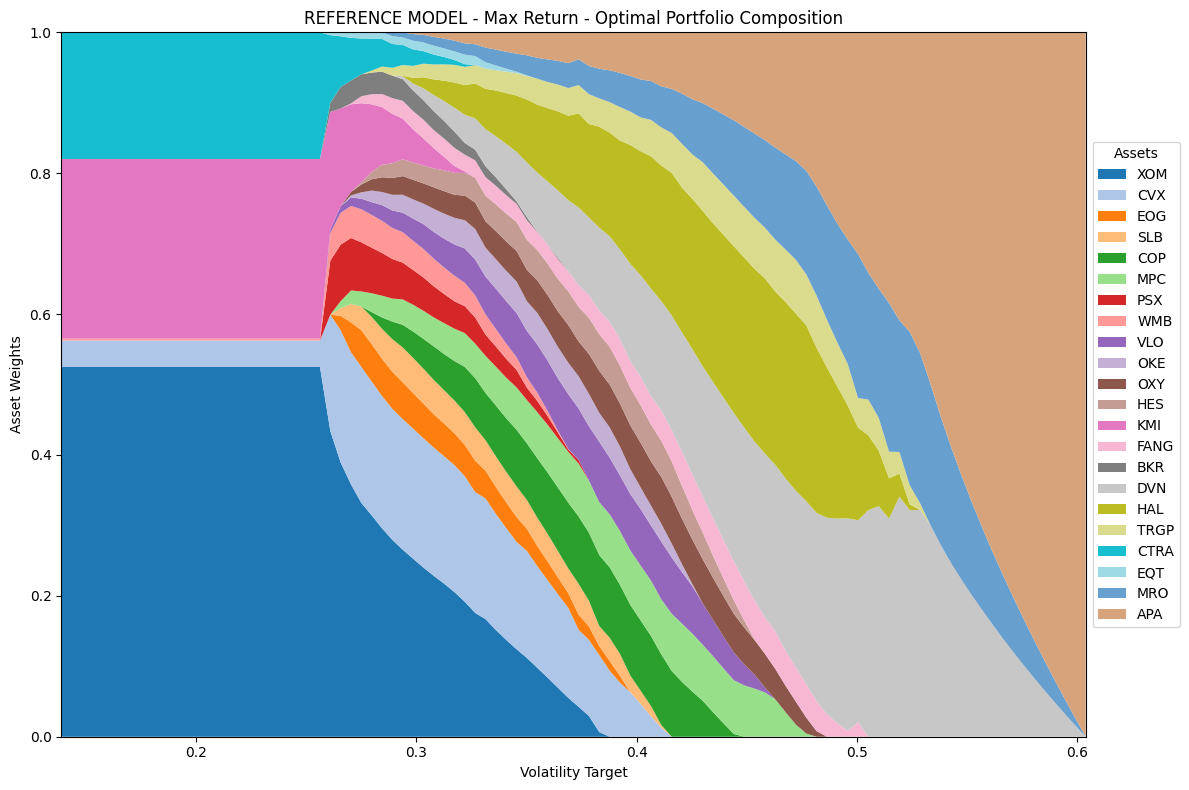

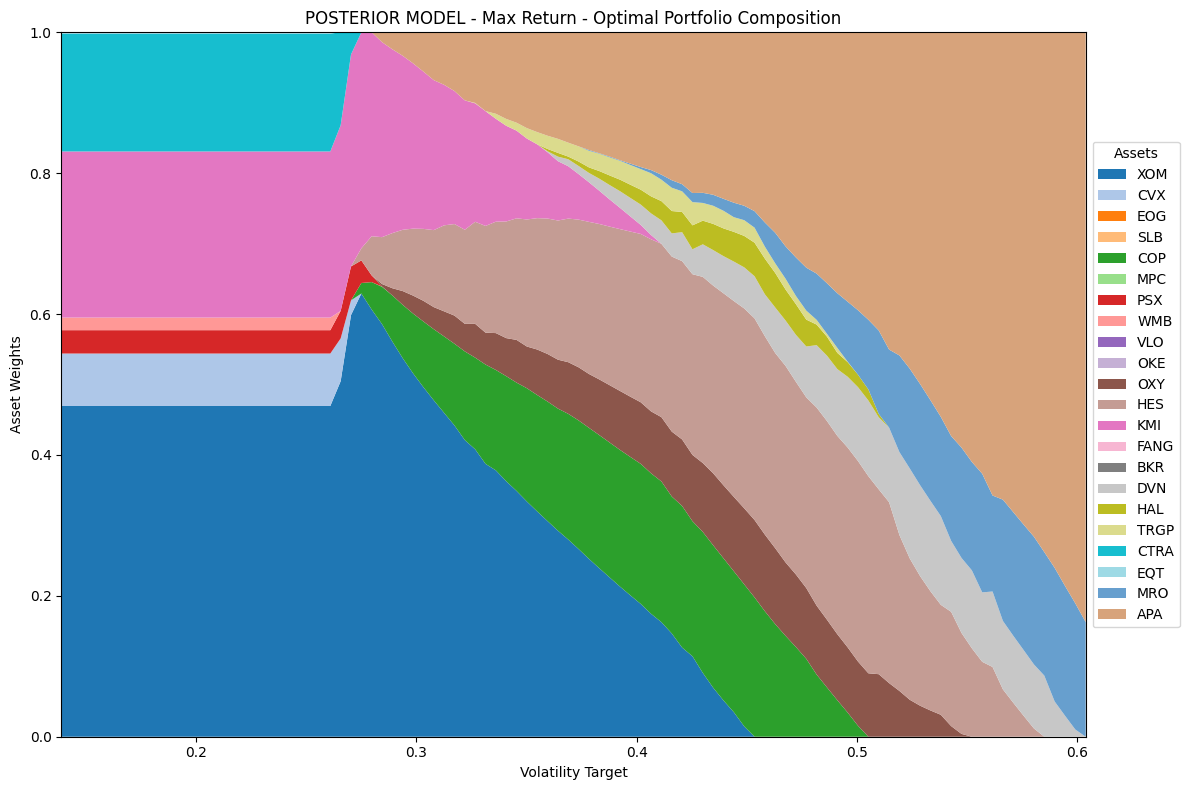

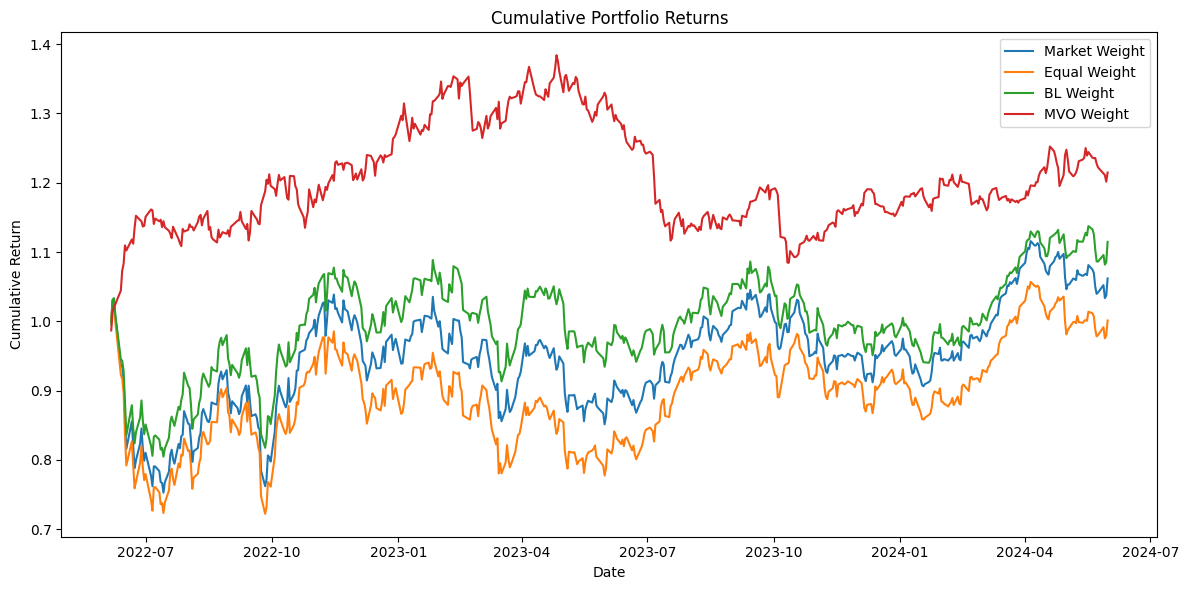

In [27]:
''' =========================================================================================================
    Execute Script
========================================================================================================= '''


def main():
    # Configuration
    etf_info = load_etf_info()
    tickers = pd.Series(etf_info['Ticker'])
    _date_start, _date_end = '2014-08-22', '2024-08-22'

    _map_calls = {2: 'Winner', 1: 'Overweight', 0: 'Neutral', -1: 'Underweight', -2: 'Loser'}
    _calls = {'KMI': 2, 'XOM': 2, 'APA': 1, 'COP': 1, 'HES': 1, 'SLB': -1, 'EQT': -1, 'CVX': -1, 'CTRA': -2, 'WMB': -2}
    _call_pct, _add_vols = 0.05, False

    _lambda_values = {'Average': 1.12 / 2, 'Trustee': 3 / 2, 'Kelly': 0.02 / 2}
    _tau = 0.4

    # Run Black-Litterman for different lambda values
    results = {}
    for name, lambda_param in _lambda_values.items():
        results[name] = run_black_litterman(_date_start, _date_end, tickers, etf_info, lambda_param, _tau, _calls,
                                            _map_calls, _call_pct, _add_vols, excess_adjust=True)

    # Portfolio Optimization
    _long_only = True
    _max_weight = 1.0
    summary = results['Average'][0]
    rets_prior = results['Average'][2]
    cov_prior = results['Average'][3]
    rets_post = results['Average'][4]
    cov_post = results['Average'][5]
    weights_mvo = pd.DataFrame(results['Average'][1], index=tickers, columns=['MVO Weight'])
    vol_targets = np.linspace(np.min(summary['Historical Vol']) / 2, np.max(summary['Historical Vol']), 100)

    # quick, simple analytical solution as example
    analytical_solution = analytical_min_vol(rets_post, cov_post, _return_target=0.1608)

    # now that we have that down, let's use scipy for more complex optimizations
    if _long_only:
        bounds = tuple((0, _max_weight) for _ in range(tickers.shape[0]))
    else:
        bounds = tuple((-_max_weight, _max_weight) for _ in range(tickers.shape[0]))

    optimizer_reference = run_optimizer(objective_function_maxret, tickers, rets_prior, cov_prior, vol_targets, bounds)
    fig_reference = plot_portfolio_composition(optimizer_reference, tickers,
                                               title='REFERENCE MODEL - Max Return - Optimal Portfolio Composition')

    optimizer_posterior = run_optimizer(objective_function_maxret, tickers, rets_post, cov_post, vol_targets, bounds)
    fig_posterior = plot_portfolio_composition(optimizer_posterior, tickers,
                                               title='POSTERIOR MODEL - Max Return - Optimal Portfolio Composition')

    # Run portfolio comparison
    bl_output = {
        'tickers': tickers,
        'etf_info': etf_info,
        'date_start': _date_start,
        'date_end': _date_end,
        'map_calls': _map_calls,
        'calls': _calls,
        'call_pct': _call_pct,
        'add_vols': _add_vols,
        'lambda_values': _lambda_values,
        'tau': _tau,
        'results': results
    }

    fig_returns, table_list_factors, table_list_performance = portfolio_comparison(bl_output, optimizer_posterior, weights_mvo)

    # Export Figures to PDF
    add_figs_to_pdf([fig_reference, fig_posterior, fig_returns],
                    output_directory='outputs/',
                    file_name='BL_Summary_Plots')

    # Export Tables to Excel
    with pd.ExcelWriter('outputs/BL_Summary_Tables.xlsx') as writer:
        # add BL optimization results by lambda
        n = 0
        for name, (summary, weights_opt, rets_prior, cov_prior, rets_post, cov_post) in results.items():
            summary['Lambda Type'] = name
            summary = summary[['Lambda Type'] + summary.columns[:-1].tolist()]
            summary.to_excel(writer, sheet_name='Optimal Weight Summary', startrow=n)
            n += summary.shape[0] + 2
        # add portfolio factor comparisons
        n = 0
        table_list_factors[0].to_excel(writer, sheet_name='Factor Data', startrow=n)
        n += table_list_factors[0].shape[0] + 2
        table_list_factors[1].to_excel(writer, sheet_name='Factor Data', startrow=n)
        n += table_list_factors[1].shape[0] + 2
        table_list_factors[2].to_excel(writer, sheet_name='Factor Data', startrow=n)
        # add portfolio performance comparisons
        n = 0
        table_list_performance[0].to_excel(writer, sheet_name='Performance Data', startrow=n)
        n += table_list_performance[0].shape[0] + 2
        table_list_performance[1].to_excel(writer, sheet_name='Performance Data', startrow=n)
        n += table_list_performance[1].shape[0] + 2
        table_list_performance[2].to_excel(writer, sheet_name='Performance Data', startrow=n)


if __name__ == "__main__":
    main()
    print('\nDone')


# Analysis of Results, Discussion

Great, now we can look into our results.

I'll do this in order -- if we can remember all the hoops we just jumped through.

## BL Optimization Under Various Risk Aversion Criteria
This is the first tab in the excel output "BL_Summary_Tables.xlsx"

We calculated posterior returns and optimized an unconstrained allocation for three different risk-aversions: Trustee (Low risk), Average, and Kelly (High risk). So we'd expect our optimal allocations to reflect that. Lower risk means more diversified, smaller deviations from the benchmark (active share), and vice versa for Kelly. Though regardless of risk aversion, our views should still be implemented in each portfolio, just to varying degrees.

First check -- is our sum of active share for the Buys positive, and is our sum of active share for the Sells negative? Yes.

Second check -- are our quantitative views also aligned with our qualitative "calls"? Yes.

Third check -- is full Kelly absurd? Very much Yes.

## Comparison of Reference and Posterior Allocations Under Various Vol Targets
These are the first two plots of the PDF "BL_Summary_Plots.pdf"

These plots show various portfolio allocations (stack plot of optimal portfolio weights) under different vol target conditions -- remember our scipy optimizer has the objective of max return under criteria of long only and full investment.

The reference portfolio, using market equilibrium returns and covariance estimates, is pretty well diversified once we get beyond the lower bound of vol possible in a long-only book of these stocks. We start out targeting low vol, so we get lower vol stocks with lower pairwise correlations. As the vol target increases we add some higher vol / smaller names, and our Sharpe definitely increases here. Then at the upper end we see the portfolio becomes dominated by APA -- the smallest and most volatile of the XLE universe. That's exactly what we'd expect.

For our posterior model, we see similar trends in general, but notice the important differences -- we remain overweight our biggest winners (XOM, KMI) for longer than the reference model. This is because we told the BL model that the risk/return tradeoff is actually better than what the market is pricing. Same goes with APA, we called this an "outperform" -- so it comes into our max return portfolio much sooner despite it's high vol.

This is the BL model at work -- reflecting our qualitative views not only through quantitative return estimations, but importantly in our portfolio allocation. And all we had to do was add some names to a few Buy/Sell buckets (and, yes, maybe some fundamental research to back it up).

## Portfolio Analysis
This analysis spans the last two tabs in the Excel output, as well as the final plot in our PDF.

Remember, we chose 4 portfolios to analyze above.

### Returns
Looking at the cumulative return plot: First thing that jumps out -- my views were spot on. Pat on the back there.

How do I know? Well, our long-only BL-optimized portfolio (green line) solidly outperforms the market- and equal-weighted portfolios. Also -- the L/S expression of these views clearly kills them all.

Skip ahead to the last tab in the excel output to see the performance stats we calculated. Our long-only BL portfolio has a higher return, lower vol, and thus higher Sharpe than the market- and equal-weighted benchmarks. It also has a lower max drawdown -- though look, it happened on the same day as the benchmark portfolios. We can be confident that the market was down those days, and our market beta / exposure in those portfolios hurt us.

But look at the L/S portfolio. Our longs solidly out-performed our shorts. We have a 0.7 Sharpe over the 2-year period. If I had 10 of those (liquid strategies) going I'd have a hedge fund on my hands. I won't go into details on combining signals because Michael Isichenko already did in his book Quantitative Portfolio Management.

Why did our L/S portfolio perform so well, with a predictably higher Sharpe, than even our own BL optimized portfolio reflecting the same views? Well look no further than the second tab in the excel output. We knew ex-ante that our factor exposures would be lower, and particularly the exposure to market beta. That's what happens when you run a net 0 book -- since every stock has a (+) market beta loading, a long-only strategy can't hide when the market tanks. But our L/S portfolio is independent of this factor -- we formulaicly reduced our exposure to the market. So we don't have to worry about it getting in the way of us monetizing our idiosyncratic views. More Alpha.

Take this as your cue to call up your friendly local prime broker, put up some margin, locate some shorts, and get after it. What could go wrong! Just kidding. Nothing wrong with exposure to the market as long as you can relax and invest for the long run. Much easier that way.

The last piece -- last tab of the excel output, we show rolling correlations of our chosen portfolios and the individual stocks on two days. The first is the max drawdown for our long-only books, and the second date is the max drawdown of our L/S book. You might notice the stocks and the LO books are highly correlated on the first day. This is the toxic part of market exposure. But on the second day -- not so correlated? Our L/S book just underperforms because of either 1. latent factor exposures (not ideal, need better optimization), or 2. a couple bad beats among our winners and/or solid performance from our shorts. That's ok! That will happen. Our hit rate will ideally be in the 51-55% range, so we're going to have drawdowns. (Especially if we set our views once and backtest performance over 2 years).

# Conclusion

What is there to say that hasn't already been said? BL does a pretty good job of turning simple qualitative calls into a solid portfolio that doesn't risk too much deviating from the market. Or alternatively, it can give us a great L/S expression of our views that lowers risk and improves returns (assuming we are good at generating views).

For further improvement, I'd consider a step beyond factor loadings -- calculating alpha returns. That's what we want to predict after all. Or call up MSCI or Axioma and they'll give them to you (for a price). By definition we assume the alpha returns are uncorrelated / idiosyncratic. Then we can estimate alpha returns and optimize a portfolio the reflects those specific views in alpha return space as opposed to total return space.

Alternatively, you could add a constraint in your optimizer that sets a minimum Alpha Risk Contribution %. We're ok with a little factor risk, and we don't care which factors necessarily, but as long as it's, say, below X%, then we should be confident that whatever happens, it's alpha driving the bus.

Lastly, I won't go into (any) detail here -- but for the best paper I've read on optimization, see Multi-Period Trading via Convex Optimization by Stephen Boyd. It goes far beyond the naive single-period optimizations we have above and allows for combining many signals across multiple time horizons -- taking into account the all-important trading costs.

I hope this was helpful. Good luck.

Thanks to those reserachers I noted above, particularly Attilio Meucci and Michael Isichenko.